In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集

In [4]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

## 转换为Tensor

In [5]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.0283],
         [-1.0228]]),
 tensor([[ 1.0000e+00, -2.8277e-02,  3.9980e-04, -3.7685e-06,  2.6641e-08,
          -1.5066e-10,  7.1007e-13, -2.8684e-15,  1.0139e-17, -3.1855e-20,
           9.0079e-23, -2.3156e-25,  5.4566e-28, -1.1869e-30,  2.3973e-33,
          -4.5194e-36,  7.9872e-39, -1.3286e-41,  2.1019e-44, -0.0000e+00],
         [ 1.0000e+00, -1.0228e+00,  5.2301e-01, -1.7830e-01,  4.5590e-02,
          -9.3255e-03,  1.5896e-03, -2.3225e-04,  2.9692e-05, -3.3742e-06,
           3.4510e-07, -3.2086e-08,  2.7347e-09, -2.1515e-10,  1.5717e-11,
          -1.0717e-12,  6.8502e-14, -4.1212e-15,  2.3417e-16, -1.2605e-17]]),
 tensor([5.0450, 0.9750]))

## 评估给定数据集上的loss 

In [6]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [7]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):    
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.992326   1.1975623 -3.3872726  5.602879 ]]


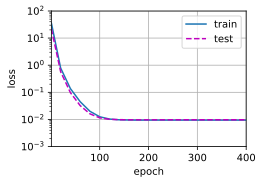

In [8]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.2002945 5.1681614]]


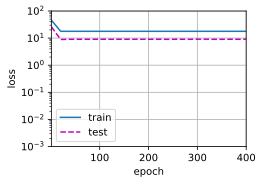

In [9]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.000448    1.3124119  -3.4494793   5.0501714   0.09685928  1.264824
   0.29053086  0.18699944 -0.02517072  0.1577718  -0.00644078 -0.00822897
  -0.17457011 -0.18767545 -0.22352113 -0.12484847  0.06030419  0.19891019
  -0.09687062  0.02887857]]


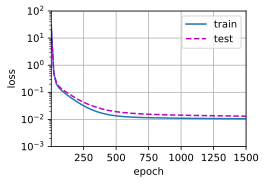

In [10]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)